# Demo Final: Detector de Plazas de Parking

Este notebook es la **demostración final** del proyecto. 

1. **Métricas Globales**: Calcula qué tan bien funciona el modelo en TODAS las imágenes etiquetadas.
2. **Prueba Visual**: Muestra una cuadrícula de **9 imágenes aleatorias** con las predicciones.

### Características del Modelo
- **Bordes**: Detecta la forma del coche.
- **Textura**: Diferencia entre superficies lisas (asfalto) y complejas (coches).
- **Color (Saturación)**: Ayuda a distinguir coches de colores del suelo gris.

In [1]:
import cv2
import numpy as np
import pickle
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Configuración
DATA_DIR = Path("data")
GT_FILE = "ground_truth.json"
MODEL_FILE = "model.pkl"
PLAZAS_FILE = "plazas.pickle"

# Colores para visualización
GREEN = (0, 255, 0)  # Libre
RED = (0, 0, 255)    # Ocupado

## 1. Cargar Modelo, Plazas y Etiquetas (Ground Truth)

In [2]:
if not Path(MODEL_FILE).exists() or not Path(PLAZAS_FILE).exists() or not Path(GT_FILE).exists():
    print("⚠️ Error: Faltan archivos. Asegúrate de haber ejecutado detector_ml.ipynb y configurar_plazas.py")
else:
    # Cargar Modelo
    with open(MODEL_FILE, 'rb') as f:
        data = pickle.load(f)
        model = data['model']
        scaler = data['scaler']
    
    # Cargar Plazas
    with open(PLAZAS_FILE, 'rb') as f:
        plazas = pickle.load(f)
        
    # Cargar Ground Truth
    with open(GT_FILE, 'r') as f:
        ground_truth = json.load(f)
        
    print(f"✅ Modelo cargado.")
    print(f"✅ {len(plazas)} plazas configuradas.")
    print(f"✅ {len(ground_truth)} imágenes etiquetadas disponibles para test.")

✅ Modelo cargado.
✅ 51 plazas configuradas.
✅ 8 imágenes etiquetadas disponibles para test.


## 2. Pipeline de Procesamiento

In [3]:
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(gray)
    return cv2.GaussianBlur(gray, (5, 5), 0)

def get_features(roi_gray, roi_binary, roi_color):
    pixels = cv2.countNonZero(roi_binary)
    texture = cv2.meanStdDev(roi_gray)[1][0][0]
    hsv = cv2.cvtColor(roi_color, cv2.COLOR_BGR2HSV)
    saturation = cv2.meanStdDev(hsv[:,:,1])[0][0][0]
    return [pixels, texture, saturation]

def predict_image(image, plazas, model, scaler):
    processed = preprocess(image)
    binary = cv2.adaptiveThreshold(processed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                 cv2.THRESH_BINARY_INV, 25, 15)
    binary = cv2.medianBlur(binary, 5)
    
    results = []
    for rect in plazas:
        x, y, w, h = rect
        roi_g = processed[y:y+h, x:x+w]
        roi_b = binary[y:y+h, x:x+w]
        roi_c = image[y:y+h, x:x+w]
        
        feats = get_features(roi_g, roi_b, roi_c)
        feats_scaled = scaler.transform([feats])
        
        pred = model.predict(feats_scaled)[0]
        results.append(pred)
        
    return results

## 3. Evaluar Rendimiento Global
Vamos a pasar el modelo por TODAS las imágenes etiquetadas para ver la precisión real.

⏳ Calculando métricas en todo el dataset...

🏆 Precisión Global: 99.51%

📜 Reporte de Clasificación:
              precision    recall  f1-score   support

       Libre       1.00      0.98      0.99        85
     Ocupado       0.99      1.00      1.00       323

    accuracy                           1.00       408
   macro avg       1.00      0.99      0.99       408
weighted avg       1.00      1.00      1.00       408



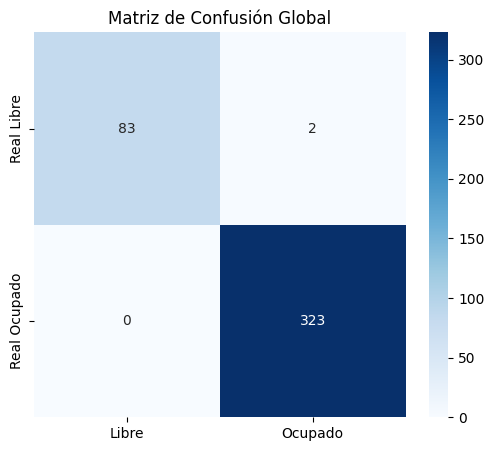

In [4]:
y_true_all = []
y_pred_all = []

print("⏳ Calculando métricas en todo el dataset...")

for img_name, labels in ground_truth.items():
    img_path = DATA_DIR / img_name
    if not img_path.exists(): continue
    
    image = cv2.imread(str(img_path))
    predictions = predict_image(image, plazas, model, scaler)
    
    # Solo comparamos hasta donde tengamos etiquetas (por seguridad)
    limit = min(len(labels), len(predictions))
    y_true_all.extend(labels[:limit])
    y_pred_all.extend(predictions[:limit])

accuracy = accuracy_score(y_true_all, y_pred_all)
print(f"\n🏆 Precisión Global: {accuracy*100:.2f}%")
print("\n📜 Reporte de Clasificación:")
print(classification_report(y_true_all, y_pred_all, target_names=['Libre', 'Ocupado']))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true_all, y_pred_all), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Libre', 'Ocupado'], yticklabels=['Real Libre', 'Real Ocupado'])
plt.title('Matriz de Confusión Global')
plt.show()

## 4. Prueba Visual (9 Imágenes)
Ejecuta esta celda para ver 9 ejemplos aleatorios del funcionamiento.

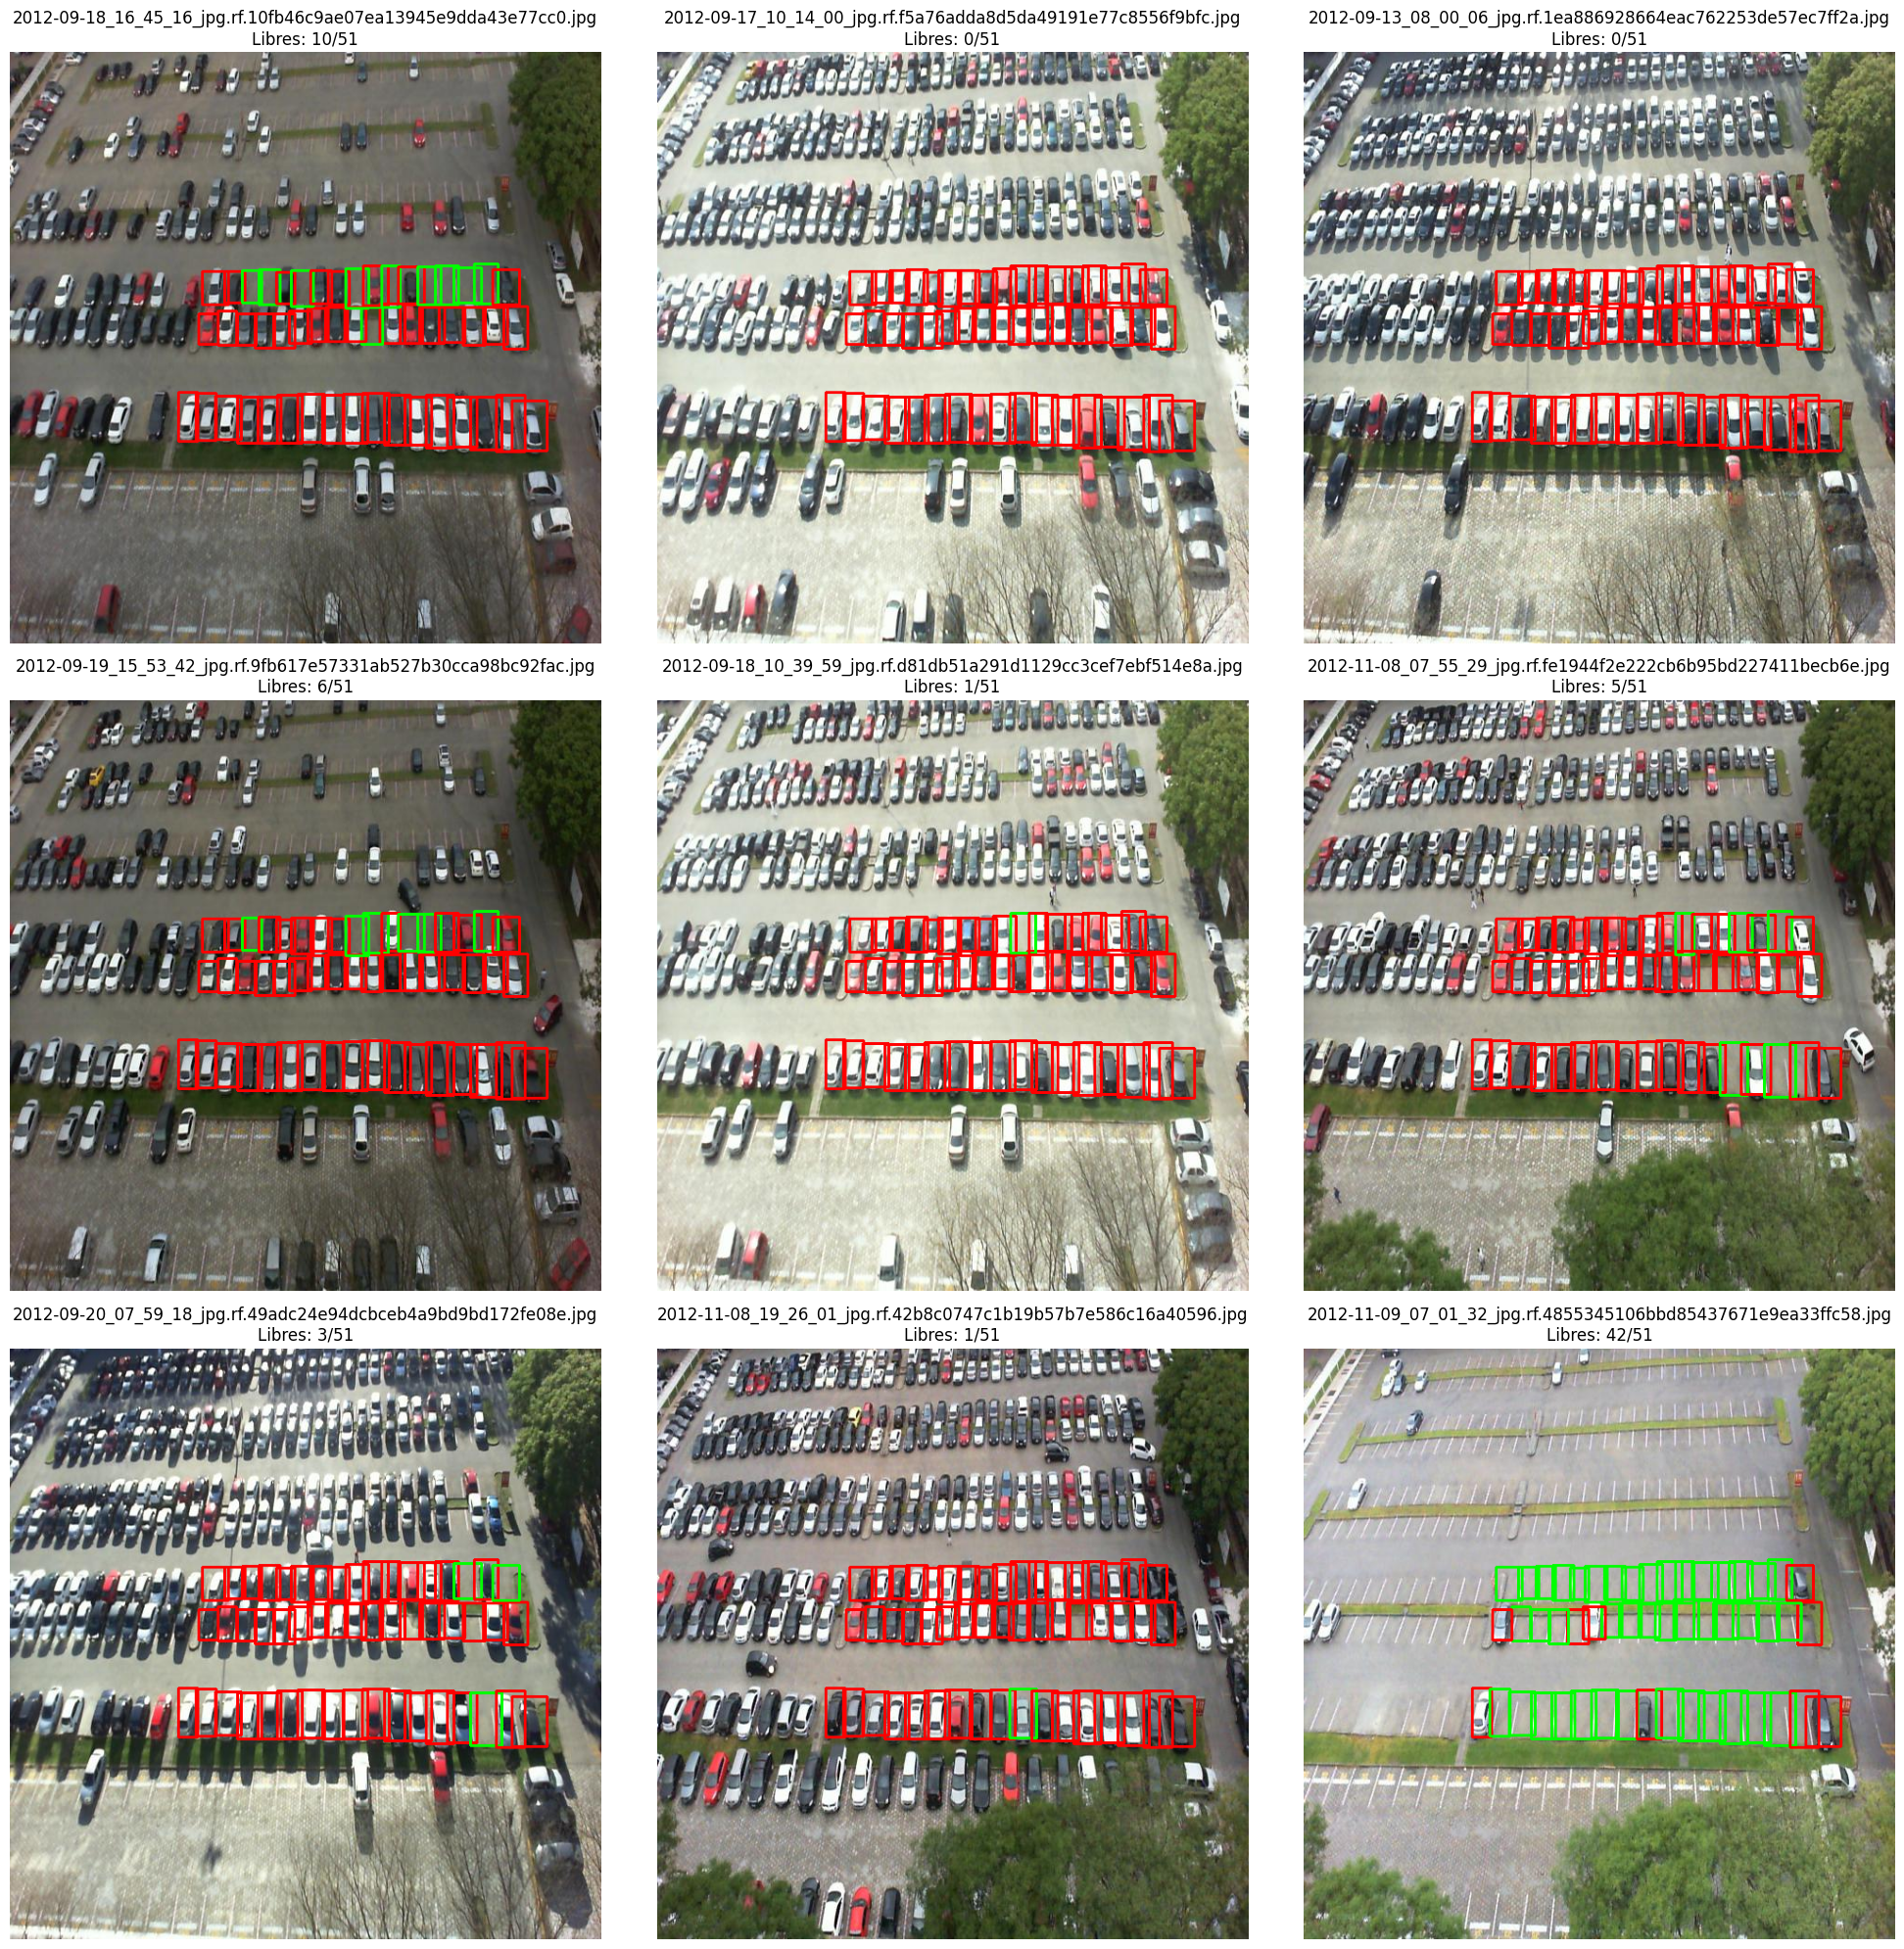

In [24]:
all_images = list(DATA_DIR.glob("*.jpg"))

if len(all_images) < 9:
    print("⚠️ Necesitas al menos 9 imágenes en data/ para esta demo.")
else:
    selected_images = random.sample(all_images, 9)
    
    plt.figure(figsize=(20, 20))
    
    for i, img_path in enumerate(selected_images):
        img = cv2.imread(str(img_path))
        
        # Inferencia
        statuses = predict_image(img, plazas, model, scaler)
        
        # Dibujar
        output = img.copy()
        free = 0
        for rect, status in zip(plazas, statuses):
            x, y, w, h = rect
            color = GREEN if status == 0 else RED
            if status == 0: free += 1
            cv2.rectangle(output, (x, y), (x+w, y+h), color, 2)
            
        # Subplot 3x3
        plt.subplot(3, 3, i+1)
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        plt.title(f"{img_path.name}\nLibres: {free}/{len(plazas)}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()